In [1]:
import subprocess
import sys

try:
    from autogluon.tabular import TabularPredictor
    print("AutoGluon is already installed.")
except ImportError:
    print("AutoGluon is not installed. Installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "autogluon.tabular"])
    print("AutoGluon installed.")


AutoGluon is not installed. Installing...
AutoGluon installed.


In [2]:
from autogluon.tabular import TabularPredictor
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score


from google.colab import drive
drive.mount('/content/drive')

# GPU or CPU
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

Mounted at /content/drive
cpu


### **1. Dataset**

In [3]:
# Data source
data = pd.read_csv('/content/drive/MyDrive/PhD 2024/Dataset/data_office_1.csv')
data['date'] = pd.to_datetime(data['timestamp'])
data.set_index('date', inplace=True)


# Find discontinuous timestamps
time_diffs = data.index.to_series().diff()
irregular_timestamps = data.index[time_diffs != pd.Timedelta(minutes=5)]
print("Discontinuous timestamps:")
print(irregular_timestamps)


# Choose the time interval of input data
data_temp1 = data.loc['2021-09-07':'2021-09-08'].copy()
data_temp2 = data.loc['2021-09-10':'2021-09-10'].copy()
data_temp3 = data.loc['2021-09-13':'2021-09-17'].copy()
data_temp4 = data.loc['2021-09-20':'2021-09-23'].copy()

# Prepare for combining the time-series data
data_temp2.index = data_temp2.index.map(lambda x: x.replace(day=9))
date_offset = pd.DateOffset(days=-3)
data_temp3.index = data_temp3.index.map(lambda x: x + date_offset)
date_offset_5_days = pd.DateOffset(days=-5)
data_temp4.index = data_temp4.index.map(lambda x: x + date_offset_5_days)

data_combined = pd.concat([data_temp1, data_temp2, data_temp3, data_temp4])
data_selected = data_combined
print("data_combined.shape:", data_combined.shape)

unique_days = data_combined.index.date
print("Total days:", pd.Series(unique_days).nunique())

Discontinuous timestamps:
DatetimeIndex(['2021-09-07 00:00:00+08:00', '2021-09-10 00:00:00+08:00',
               '2021-09-13 00:00:00+08:00', '2021-09-20 00:00:00+08:00',
               '2021-09-27 00:00:00+08:00', '2021-12-09 00:00:00+08:00',
               '2021-12-13 00:00:00+08:00', '2021-12-20 00:00:00+08:00'],
              dtype='datetime64[ns, UTC+08:00]', name='date', freq=None)
data_combined.shape: (3456, 35)
Total days: 12


X_train.shape: (2880, 7)
X_test.shape: (576, 7)
Y_train.shape: (2880,)
Y_test.shape: (576,)


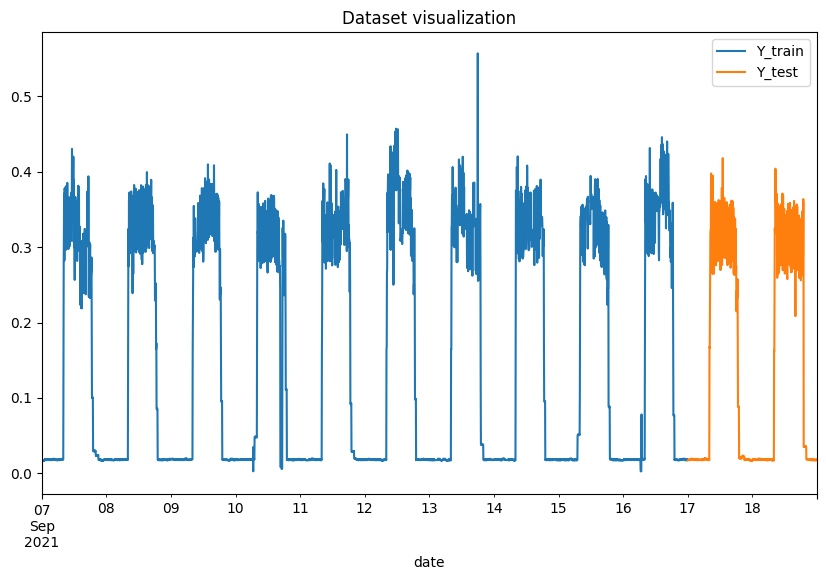

In [4]:
# Create features and labels DataFrame
features = data_selected[['occupant_count [number]', 'air_temperature [Celsius]',
                          'indoor_relative_humidity [%]','dry_bulb_temp [Celsius]',
                          'outdoor_relative_humidity [%]', 'wind_speed [m/s]',
                          'global_horizontal_solar_radiation [W/m2]']].copy()
X = features.copy()
labels = data_selected[['ceiling_fan_energy [kWh]', 'chilled_water_energy [kWh]',
                        'ahu_fan_energy [kWh]']].copy()

labels['total_energy'] = labels.sum(axis=1)
Y_sum = labels['total_energy'].copy()

# Exception handling
Y_sum.loc['2021-09-10 17:25:00'] = (Y_sum.loc['2021-09-10 17:20:00'] + Y_sum.loc['2021-09-10 17:30:00'])/2


# Split data into train and test sets
train_size = 288*10
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y_sum[:train_size], Y_sum[train_size:]
print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_train.shape:', Y_train.shape)
print('Y_test.shape:', Y_test.shape)

plt.figure(figsize=(10, 6))
Y_train.plot(label="Y_train")
Y_test.plot(label="Y_test")
plt.legend()
plt.title("Dataset visualization")
plt.show()

### **2. Training**

In [5]:
train_data = pd.concat([X_train, Y_train], axis=1)
predictor = TabularPredictor(label='total_energy',
                             problem_type='regression',
                             path='/content/drive/MyDrive/PhD 2024/model_AutoGluon/')
predictor.fit(train_data)


Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       11.22 GB / 12.67 GB (88.5%)
Disk Space Avail:   14.22 GB / 15.00 GB (94.8%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference spee

In [6]:
#predictor.save()

In [7]:
leaderboard = predictor.leaderboard()
leaderboard

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.030622,root_mean_squared_error,0.276393,103.595735,0.000635,0.013366,2,True,11
1,NeuralNetTorch,-0.032141,root_mean_squared_error,0.009692,95.200660,0.009692,95.200660,1,True,9
2,ExtraTreesMSE,-0.032494,root_mean_squared_error,0.133598,2.719091,0.133598,2.719091,1,True,6
3,RandomForestMSE,-0.033118,root_mean_squared_error,0.085170,4.313885,0.085170,4.313885,1,True,5
4,XGBoost,-0.033262,root_mean_squared_error,0.008937,1.316246,0.008937,1.316246,1,True,8
5,LightGBMXT,-0.034194,root_mean_squared_error,0.036483,7.382796,0.036483,7.382796,1,True,3
6,LightGBMLarge,-0.034301,root_mean_squared_error,0.007792,1.343924,0.007792,1.343924,1,True,10
7,LightGBM,-0.037883,root_mean_squared_error,0.005957,0.567355,0.005957,0.567355,1,True,4
8,NeuralNetFastAI,-0.039701,root_mean_squared_error,0.026473,4.262929,0.026473,4.262929,1,True,7
9,KNeighborsDist,-0.044471,root_mean_squared_error,0.038361,0.032486,0.038361,0.032486,1,True,2


### **3. Prediction and Evaluation**

{'root_mean_squared_error': -0.03839571616421796, 'mean_squared_error': -0.0014742310197631886, 'mean_absolute_error': -0.020520007664095403, 'r2': 0.9330981864951243, 'pearsonr': 0.9715392427046246, 'median_absolute_error': -0.004789326019302348} 

Best model used by the predictor: WeightedEnsemble_L2 

MAPE: 21.549%
R²: 0.926
RMSE: 0.040


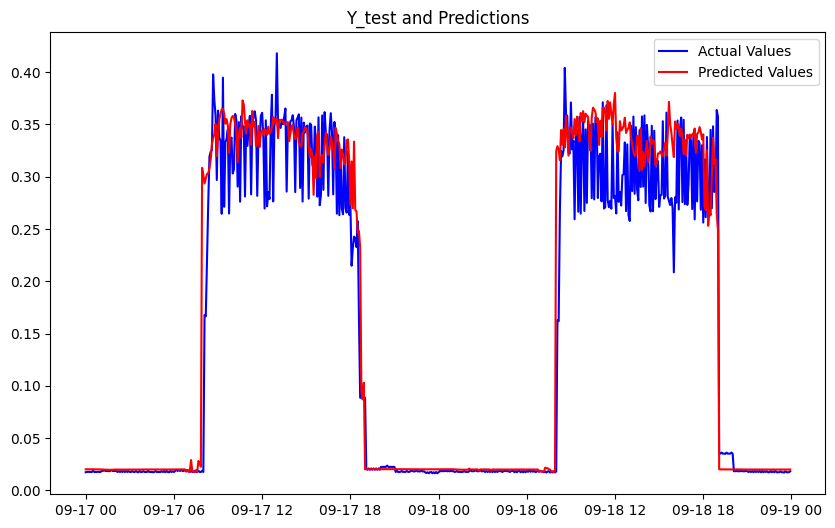

In [22]:
test_data = pd.concat([X_test, Y_test], axis=1)
predictions = predictor.predict(test_data, model='NeuralNetTorch')


performance = predictor.evaluate(test_data)
print(performance, '\n')


best_model = predictor.model_best
print("Best model used by the predictor:", best_model, '\n')


# Evaluate by MAPE, R2 and RMSE
non_zero_mask = Y_test != 0
filtered_Y = Y_test[non_zero_mask]
filtered_predictions = predictions[non_zero_mask]
mape_value = mean_absolute_percentage_error(filtered_Y, filtered_predictions) * 100
print(f"MAPE: {mape_value:.3f}%")

r2_value = r2_score(Y_test, predictions)
print(f"R²: {r2_value:.3f}")

rmse_value = np.sqrt(mean_squared_error(Y_test, predictions))
print(f"RMSE: {rmse_value:.3f}")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(Y_test.index, Y_test, label='Actual Values', color='blue')
plt.plot(predictions.index, predictions, label='Predicted Values', color='red')
plt.title('Y_test and Predictions')
plt.legend()

In [9]:
import autogluon.tabular
print(autogluon.tabular.__version__)

1.2
